# Predicting West Nile Virus with CART Based Models

Here, we consider the results of decision tree type models in predicting the presence of West Nile.  Many of the results are carried over from the previous notebooks.  We only note considerations in fitting the model here, and compare the results to those obtained when testing the model against years never seen.  It is found that not allowing trees to grow with no depth limit always results in an overfit system, while the use of shallow trees is questionable and never replicates the results of the naive logistic regression found previously.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [2]:
np.random.seed(1)

In [3]:
train = pd.read_csv('../data/train.csv', parse_dates=[0], index_col=0)

In [4]:
def combine_rows(df):
    place_table = df[[
        'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'
    ]].drop_duplicates().set_index(['Address'])

    totals = df.groupby([df.index, 'Trap', 'Address', 'Species']).NumMosquitos.sum()
    has_nile = df.groupby([df.index, 'Trap', 'Address', 'Species']).WnvPresent.sum().map(lambda x: int(x > 0))
    return pd.concat([totals, has_nile], axis=1).reset_index().merge(place_table.drop('Trap', axis=1), on='Address')

In [5]:
def deal_w_stations(df2, weather):
    station1Lat = 41.995
    station1Lon = -87.933
    station2Lat = 41.786
    station2Lon = -87.752

    dist1 = abs((df2.Latitude - station1Lat)*1j + (df2.Longitude - station1Lon))
    dist2 = abs((df2.Latitude - station2Lat)*1j + (df2.Longitude - station2Lon))
    compare = dist1 < dist2
    weather_fields = weather.select_dtypes([float,int]).columns[1:]

    for field in weather_fields:
        df2[field] = df2[field + '_x']*compare + df2[field + '_y']*(1-compare)

    redundant_cols = [name for name in df2.columns if '_' in name]

    return df2.drop(redundant_cols, axis=1)

In [6]:
shift_dict_default = {
        'Tmin':7,
        'Tmax':7,
        'Tavg':7,
        'sundiff':31
}

In [7]:
def weatherShiftLogic(col, shift_dict=shift_dict_default):
    if col.name in shift_dict:
        return col.shift(shift_dict[col.name])
    else:
        return col.shift(21)

In [8]:
def merge_weather(df):
    weather = pd.read_csv('../data/ps_weather_processed.csv', parse_dates=[0], index_col=0)\
                .apply(lambda col: col.replace('-',None).ffill().astype(int) if col.name in ['Sunrise', 'Sunset'] else col)\
                .assign(HCDiff = lambda df: df.Heat - df.Cool, sundiff= lambda df: df.Sunset - df.Sunrise)\
                .drop(['Heat', 'Cool','isRain'], axis=1)

    a = weather.query('Station==1').drop('Station', axis=1).select_dtypes([float,int]).apply(weatherShiftLogic)
    b = weather.query('Station==2').drop('Station', axis=1).select_dtypes([float,int]).apply(weatherShiftLogic)
    df = df.set_index('Date').join([a, b]).dropna()
    return deal_w_stations(df, weather)

In [9]:
def adjust_columns(df2):
    relevant_species = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
    for species in relevant_species:
        df2[species] = df2.Species.map(lambda x: int(x==species))
    df2 = df2.assign(month = df2.index.month, year=df2.index.year)
    df2 = df2.select_dtypes([int, float]).drop(['Block', 'AddressAccuracy'], axis=1)
    return df2

In [10]:
def naivestrap(x, y):
    positive_index = y.reset_index().query('WnvPresent==1').index
    indices = np.random.choice(positive_index, size=len(y)-y.sum())
    return x.copy().iloc[indices,:], y.copy().iloc[indices]

In [11]:
df2 = combine_rows(train)

In [12]:
df2 = merge_weather(df2)

In [13]:
df2 = adjust_columns(df2)

## Random Forest

First, we consider the results of a random forest model, fitting with no consideration for the time dependence of West Nile beyond naming a month for the rows.  Years were named as well, though it will be seen that they are never used by the ensembles.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [15]:
x = df2.drop(['WnvPresent','NumMosquitos'], axis=1)
y = df2.WnvPresent

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

In [16]:
xtrainint, ytrainint = naivestrap(xtrain, ytrain)
xtrain = pd.concat([xtrain, xtrainint])
ytrain = pd.concat([ytrain, ytrainint])

In [17]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(xtrain, ytrain)
model = rf
rf.score(xtest, ytest)

0.9266272189349113

In [18]:
rf.score(xtrain, ytrain)

1.0

The model seems to be very accurate, though overfit.  If we inspect the ROC AUC scores, we find more evidence that this system is in fact overfit.

In [19]:
probas = [row[1] for row in model.predict_proba(xtest)]

In [20]:
roc_auc_score(ytest, probas)

0.8099651452282158

In [21]:
roc_auc_score(ytrain, [proba[1] for proba in rf.predict_proba(xtrain)])

0.9999999999999999

The discrepancy is much more apparent here.  We move on to another model from here, but note that month and year appear relatively few times in our decision trees.  Most of the decisions stem from pinpointing location.  It could be the case that latitude and longitude are called multiple times in order to bin locations, so it may not be fair to say that location is the primary indicator of whether West Nile is present.  In fact, while we do expect West Nile closer to the airports and a lake further south, we should not expect the decision to be made on location without consideration given to at least the month of the year.

In [22]:
list(zip(xtrain.columns, model.feature_importances_))

[('Latitude', 0.21280221622148762),
 ('Longitude', 0.222735298689847),
 ('Tmax', 0.017633218205894665),
 ('Tmin', 0.02631752754495731),
 ('Tavg', 0.021417827928904686),
 ('DewPoint', 0.024858623305632797),
 ('WetBulb', 0.03040379934047124),
 ('Sunrise', 0.06341649403528159),
 ('Sunset', 0.03666379756873805),
 ('PrecipTotal', 0.008355821244173077),
 ('StnPressure', 0.018587936156653828),
 ('SeaLevel', 0.020871936689689684),
 ('ResultSpeed', 0.019372472111802857),
 ('ResultDir', 0.017777011033985164),
 ('AvgSpeed', 0.01990330035091453),
 ('HCDiff', 0.051462673419838796),
 ('sundiff', 0.03455083103203938),
 ('CULEX PIPIENS', 0.022795904608691964),
 ('CULEX PIPIENS/RESTUANS', 0.028783079349432746),
 ('CULEX RESTUANS', 0.024106000542190597),
 ('month', 0.05743443513280228),
 ('year', 0.019749795486569993)]

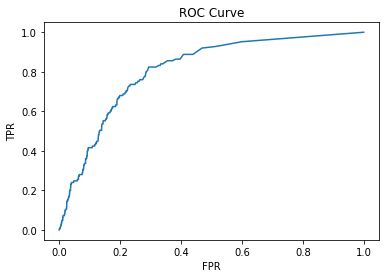

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
fpr, tpr, th = roc_curve(ytest, probas)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR');

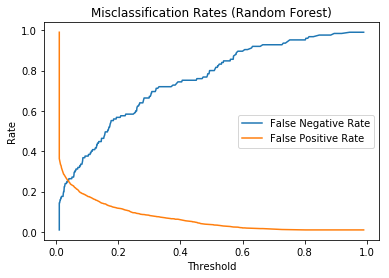

In [24]:
plt.plot(np.clip(th,0.01,0.99), np.clip(1-tpr,0.01,0.99), label='False Negative Rate');
plt.plot(np.clip(th, 0.01, 0.99), np.clip(fpr,0.01,0.99), label='False Positive Rate');
plt.legend();
plt.title('Misclassification Rates (Random Forest)');
plt.ylabel('Rate');
plt.xlabel('Threshold');

This model also has difficulties in establishing a threshold that will balance the mispredictions while prioritizing the false negative rate; instead of levelling off, it simply drops down to zero.  Simply looking at the ROC AUC hides this.

# Extra Trees Classifier

In an attempt to further reduce overfitting, we make three modifications at once; we use the extra trees classifier, we train sets of trees that can only see one year, and we change the default parameters to force our trees to be shallow learners.  While these should be experimented with separately, we simply note that the end result is still a deceptively overfit tree.

In [25]:
from sklearn.ensemble import ExtraTreesClassifier

In [26]:
extra = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=100, min_samples_split=200, warm_start=True)
extra.fit(xtrain['2007'], ytrain['2007'])
extra.score(xtest['2009':'2013'], ytest['2009':'2013'])

0.8291690877396862

In [27]:
extra.set_params(n_estimators=200)
extra.fit(xtrain['2009'], ytrain['2009'])
extra.set_params(n_estimators=300)
extra.fit(xtrain['2011'], ytrain['2011'])
extra.set_params(n_estimators=400)
extra.fit(xtrain['2013'], ytrain['2013'])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=200,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [28]:
roc_auc_score(ytest, [proba[1] for proba in extra.predict_proba(xtest)])

0.7827950207468879

In [29]:
roc_auc_score(ytrain, [proba[1] for proba in extra.predict_proba(xtrain)])

0.8055564463368373

In [30]:
list(zip(xtrain.columns, model.feature_importances_))

[('Latitude', 0.21280221622148762),
 ('Longitude', 0.222735298689847),
 ('Tmax', 0.017633218205894665),
 ('Tmin', 0.02631752754495731),
 ('Tavg', 0.021417827928904686),
 ('DewPoint', 0.024858623305632797),
 ('WetBulb', 0.03040379934047124),
 ('Sunrise', 0.06341649403528159),
 ('Sunset', 0.03666379756873805),
 ('PrecipTotal', 0.008355821244173077),
 ('StnPressure', 0.018587936156653828),
 ('SeaLevel', 0.020871936689689684),
 ('ResultSpeed', 0.019372472111802857),
 ('ResultDir', 0.017777011033985164),
 ('AvgSpeed', 0.01990330035091453),
 ('HCDiff', 0.051462673419838796),
 ('sundiff', 0.03455083103203938),
 ('CULEX PIPIENS', 0.022795904608691964),
 ('CULEX PIPIENS/RESTUANS', 0.028783079349432746),
 ('CULEX RESTUANS', 0.024106000542190597),
 ('month', 0.05743443513280228),
 ('year', 0.019749795486569993)]

In terms of tree decisions, we find mostly the same patterns as before.  We only note that there is much less disagreement with the ROC AUC scores - a boost in confidence from reviewing our previous results.  In the end, this model scores much lower than advertised on the years it hasn't seen.  We simply move on to one last attempt to make a model that can treat a test set as fairly as it treats years it has never seen.

# Gradient Boosted Trees

While the concept is completely different from the forests we have previously fit, we make one last ditch effort to fit a decision tree based model that will not overfit to the years it has seen.  Max depth is set at 2, while subsample is set at .5, in a desperate attempt to prevent overfitting to the training data.  In limiting the subsample seen at each iteration, the hope is that if there is no decision tree to universally converge to, at the very least the model will do just as terribly on any set of data rather than do well on training data.  We fit the system to progressively more years and score it against the next year, as though we were training using cross validation.  The concept comes from the time series split method, but we guarantee the split on years here.

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
grad = GradientBoostingClassifier(n_estimators=1000, subsample=.5)

In [33]:
train_scores = []
test_scores = []
roc_trains = []
roc_tests = []

In [34]:
for end_year, next_year in [('2007','2009'), ('2009', '2011'), ('2011', '2013')]:
    grad.fit(xtrain['2007':end_year], ytrain['2007':end_year])
    train_scores.append(grad.score(xtest['2007':end_year], ytest['2007':end_year]))
    test_scores.append(grad.score(xtest[next_year], ytest[next_year]))
    roc_trains.append(roc_auc_score(ytrain['2007':end_year], [proba[1] for proba in grad.predict_proba(xtrain['2007':end_year])]))
    roc_tests.append(roc_auc_score(ytest[next_year], [proba[1] for proba in grad.predict_proba(xtest[next_year])]))

In [35]:
print(train_scores)
print(test_scores)
print(roc_trains)
print(roc_tests)

[0.9004914004914005, 0.9314002828854314, 0.9307851239669421]
[0.9883333333333333, 0.9712643678160919, 0.8981636060100167]
[0.9994599021438245, 0.9993783062214309, 0.9985236594128195]
[0.5885067114093959, 0.6108949416342412, 0.7112092268877276]


In the end, this system is overfit anyway.  The accuracies converge as more years are included, but ROC AUC scores tell us that these are always overfit to the training years.  We expect this system to give us no predictive power.

In [44]:
test = pd.read_csv('../data/test.csv', parse_dates=[1])
test = merge_weather(test)
test = adjust_columns(test)
test = test.drop('Id', axis=1)

In [45]:
def kaggle_submit(test, model, filename):
    submission = pd.DataFrame([predictions[1] for predictions in model.predict_proba(test)], columns=['WnvPresent'])
    submission = submission.reset_index().rename({'index':'Id'}, axis=1)
    submission.loc[:,'Id'] = submission.Id + 1
    submission = submission.set_index('Id')
    submission.to_csv(f'../Kaggle/{filename}.csv')

In [46]:
kaggle_submit(test, rf, 'submissionrf')

In [47]:
kaggle_submit(test, extra, 'submissionextra')

In [48]:
kaggle_submit(test, grad, 'submissiongrad')